# Application: Sentiment Analysis with Logistic Regression

```{contents}
```

This is built on top of [Week 1's Assignment of the NLP Specialization.](../../../deep_learning/natural_language_processing_specialization/c1_natural_language_processing_with_classification_and_vector_spaces/w1/intro.md)

## Dependencies

In [322]:
import re
import string
import sys
from itertools import groupby
from os import getcwd
from pathlib import Path
from typing import Any, Callable, Dict, Set, Tuple, Union

import matplotlib.pyplot as plt  # Library for visualization
import nltk  # NLP toolbox
import numpy as np  # Library for math functions
import pandas as pd  # Library for Dataframes
import pytest
from nltk.corpus import twitter_samples
from rich import print
from rich.pretty import pprint

parent_dir = str(Path().resolve().parents[3])
print(parent_dir)
sys.path.append(parent_dir)

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer

from src.base.activation import Activation
from src.base.criterion import Criterion
from src.base.types import T

nltk.download("twitter_samples")

filePath = f"{getcwd()}/../tmp2/"
nltk.data.path.append(filePath)

/Users/gaohn/gaohn/gaohn-galaxy

[nltk_data] Downloading package twitter_samples to
[nltk_data]     /Users/gaohn/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!


## Type Hinting

In [323]:
Freq = Dict[Tuple[str, int], int]


## Prepare the Data

* The `twitter_samples` contains subsets of five thousand `positive_tweets`, five thousand `negative_tweets`, and the full set of 10,000 tweets.  
    * If you used all three datasets, we would introduce duplicates of the positive tweets and negative tweets.  
    * You will select just the five thousand positive tweets and five thousand negative tweets.

### Import the Data

In [324]:
# select the set of positive and negative tweets
all_positive_tweets = twitter_samples.strings("positive_tweets.json")
all_negative_tweets = twitter_samples.strings("negative_tweets.json")


Let's print out the first 5 positive and first 5 negative tweets to see how they
look like:

In [325]:
pprint(all_positive_tweets[:5])
pprint(all_negative_tweets[:5])


[
│   '#FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)',
│   '@Lamb2ja Hey James! How odd :/ Please call our Contact Centre on 02392441234 and we will be able to assist you :) Many thanks!',
│   '@DespiteOfficial we had a listen last night :) As You Bleed is an amazing track. When are you in Scotland?!',
│   '@97sides CONGRATS :)',
│   'yeaaaah yippppy!!!  my accnt verified rqst has succeed got a blue tick mark on my fb profile :) in 15 days'
]

[
│   'hopeless for tmr :(',
│   "Everything in the kids section of IKEA is so cute. Shame I'm nearly 19 in 2 months :(",
│   '@Hegelbon That heart sliding into the waste basket. :(',
│   '“@ketchBurning: I hate Japanese call him "bani" :( :(”\n\nMe too',
│   'Dang starting next week I have "work" :('
]

### Train Test Split

In the course, the author split the positive tweets into 4000 training samples and 1000 test samples. The same for the negative tweets. That's a total of 8000 training samples and 2000 test samples.

The purpose of this notebook is not to teach about best practices in modelling. So, we will use the same split as the author without shuffling the data.

In [326]:
# split the data into two pieces, one for training and one for testing (validation set)
test_pos = all_positive_tweets[4000:]
train_pos = all_positive_tweets[:4000]
test_neg = all_negative_tweets[4000:]
train_neg = all_negative_tweets[:4000]

X_train = train_pos + train_neg
X_test = test_pos + test_neg


In [327]:
print(f"Train set size: {len(X_train)}\nTest set size: {len(X_test)}")


Train set size: 8000
Test set size: 2000

### Creating Labels

Create the numpy array of positive labels and negative labels.

In [328]:
# combine positive and negative labels
y_train = np.append(np.ones((len(train_pos), 1)), np.zeros((len(train_neg), 1)), axis=0)
y_test = np.append(np.ones((len(test_pos), 1)), np.zeros((len(test_neg), 1)), axis=0)


In [329]:
print(f"y_train shape: {y_train.shape}\ny_test shape: {y_test.shape}")


y_train shape: (8000, 1)
y_test shape: (2000, 1)

### Preprocess Tweets

[This is the preprocessing step from the NLP specialization course, week 1's first lab.](../../../deep_learning/natural_language_processing_specialization/c1_natural_language_processing_with_classification_and_vector_spaces/w1/C1_W1_lecture_nb_01_preprocessing.ipynb)

* `process_tweet()`: Cleans the text, tokenizes it into separate words, removes stopwords, and converts words to stems.

`process_tweet` function:

1. Import the required libraries and modules, like PorterStemmer and stopwords from nltk, TweetTokenizer from nltk.tokenize, and re for regular expressions.
2. Define the `process_tweet` function, which takes a tweet as input and returns a list of processed words.
3. Inside the function, create a stemmer object and retrieve the list of English stopwords.
4. Remove stock market tickers (e.g., $GE) using a regular expression.
5. Remove the old-style retweet text "RT" using a regular expression.
6. Remove hyperlinks using a regular expression.
7. Remove hashtags (i.e., only the hash # sign) from the tweet using a regular expression.
8. Tokenize the tweet using the TweetTokenizer, which is case-insensitive, removes Twitter handles, and reduces the length of repeated characters.
9. Initialize an empty list to store the cleaned words.
10. Loop through the tokenized words, and for each word, check if it's not a stopword and not a punctuation mark.
11. If the conditions in step 10 are met, stem the word and append it to the cleaned words list.
12. Return the cleaned words list.

In [330]:
def process_tweet(tweet):
    """Process tweet function.
    Input:
        tweet: a string containing a tweet
    Output:
        tweets_clean: a list of words containing the processed tweet

    """
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words("english")
    # remove stock market tickers like $GE
    tweet = re.sub(r"\$\w*", "", tweet)
    # remove old style retweet text "RT"
    tweet = re.sub(r"^RT[\s]+", "", tweet)
    # remove hyperlinks
    tweet = re.sub(r"https?://[^\s\n\r]+", "", tweet)
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r"#", "", tweet)
    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)

    tweets_clean = []
    for word in tweet_tokens:
        if (
            word not in stopwords_english
            and word not in string.punctuation  # remove stopwords
        ):  # remove punctuation
            # tweets_clean.append(word)
            stem_word = stemmer.stem(word)  # stemming word
            tweets_clean.append(stem_word)

    return tweets_clean


In [331]:
# test the function below
print("This is an example of a positive tweet:")
pprint(X_train[0])
print("This is an example of the processed version of the tweet:")
pprint(process_tweet(X_train[0]))


This is an example of a positive tweet:

'#FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)'

This is an example of the processed version of the tweet:

['followfriday', 'top', 'engag', 'member', 'commun', 'week', ':)']

## Feature Extraction

The following is extracted from **Feature Extraction with Frequencies** section
of the NLP specialization. Note the images belong to the NLP specialization course
as well, symbols used in the image may differ from the content. For example, 
one of the image denote $\lvert V \lvert$ as $n$, but that is not the case, instead, 
$\lvert \mathcal{V} \lvert = V = N$.

You have to encode each tweet as a vector. Given a tweet, or some text, you can represent it as a vector of dimension 
$V$, where $V$ corresponds to your vocabulary size. Recall in [deep learning notations](../../../notations/deep_learning_notations.md), we define the set of all 
unique words/vocabulary in a corpus as $\mathcal{V}$, and the size of the vocabulary
to be $V = |\mathcal{V}|$.

As an example, we take the first tweet
"I am happy because I am learning NLP" and encode it as a vector as follows:

```{figure} ../assets/logistic_regression/nlp_spec_feature_ext_0.png
---
name: Feature Extraction with Frequencies.
---
Feature Extraction with Frequencies. Image Credit: [Natural Language Processing Specialization](https://www.coursera.org/specializations/natural-language-processing)
```

where you would put a 1 in the corresponding index for any word in the tweet, and a 0 otherwise. 

As you can see, as the corpus size increases, the set of unique words $\mathcal{V}$ increases, and so does the size of the vocabulary $V$. The vector soon becomes
[sparse](https://en.wikipedia.org/wiki/Sparse_matrix), meaning that most of the entries are 0, which may cause some problems in your learning algorithm (i.e. long training times, etc.). Furthermore, we may end up with more features than training examples, which is not ideal (i.e. overfitting).

We want to somehow transform the tweet/text into a vector with features.
One naive way is to just extract the features by counting the frequency of each word in the tweet by their corresponding sentiment (positive or negative).

Consider the corpus with positive and negative tweets as follows: 


```{figure} ../assets/logistic_regression/nlp_spec_feature_ext_1.png
---
name: Positive and Negative Tweets.
---
Some made up tweets to illustrate what are considered positive or negative tweets. Image Credit: [Natural Language Processing Specialization](https://www.coursera.org/specializations/natural-language-processing)
```

You have to encode each tweet as a vector. Previously, this vector was of dimension 
$V$. Now we can represent it with a vector of dimension 3.

To do so, you have to create a dictionary to map the word, and the class it appeared in (positive or negative) to the number of times that word appeared in its corresponding class. 


```{figure} ../assets/logistic_regression/nlp_spec_feature_ext_2.png
---
name: Frequency Table.
---
Dictionary Table mapping from `(word, class)` to its frequency. Image Credit: [Natural Language Processing Specialization](https://www.coursera.org/specializations/natural-language-processing)
```

Note the table above is defined as `freqs` in code as the dictionary
that maps `(word, class)` to its frequency in the whole corpus.

From the table {numref}`Frequency Table.` we can see that word like `happy` 
or `sad` took clear sides (i.e. mostly appeared in positive or negative tweets)
whereas more neutral words like `I` or `am` appeared in both positive and negative tweets.

Now, given the dictionary `freqs` and the tweet `I am sad, I am not learning NLP`, 
we can create a vector corresponding to the feature as follows:

```{figure} ../assets/logistic_regression/nlp_spec_feature_ext_3.png
---
name: Vector Representation (Positive).
---
Image Credit: [Natural Language Processing Specialization](https://www.coursera.org/specializations/natural-language-processing)
```

To encode the negative feature, you can do the same thing.

```{figure} ../assets/logistic_regression/nlp_spec_feature_ext_4.png
---
name: Vector Representation (Negative).
---
Image Credit: [Natural Language Processing Specialization](https://www.coursera.org/specializations/natural-language-processing)
```

It is thus not difficult to see that for this particular tweet, we can encode it
as a vector of dimension 3, where the first entry is the bias term as 1, 
the second entry is the sum of the frequency of the words in the tweet that appeared in positive tweets, and the third entry is the sum of the frequency of the words in the tweet that appeared in negative tweets.

Mathematically, we can represent the vector as follows:

$$
\boldsymbol{x}^{(n)} = \begin{bmatrix} 1 \\ \sum_{w \in \text{tweet}^{(n)}} \text{freq}(w, 1) \\ \sum_{w \in \text{tweet}^{(n)}} \text{freq}(w, 0) \end{bmatrix}
$$

### Word Frequency Dictionary

[This is the build word frequency step from the NLP specialization course, week 1's second lab.](../../../deep_learning/natural_language_processing_specialization/c1_natural_language_processing_with_classification_and_vector_spaces/w1/C1_W1_lecture_nb_02_word_frequencies.ipynb).

Let's construct the `freqs` dictionary mentioned in the previous section.

* `build_freqs()`: This counts how often a word in the 'corpus' (the entire set of tweets) was associated with a positive label `1` or a negative label `0`. It then builds the `freqs` dictionary, where each key is a `(word,label)` tuple, and the value is the count of its frequency within the corpus of tweets.

`build_freqs` function:

1. Define the `build_freqs` function, which takes a list of tweets and an `N x 1` array with the sentiment labels of each tweet (either 0 or 1) as input and returns a dictionary of word frequencies.
2. Convert the input array of sentiment labels into a list and squeeze it to remove any unnecessary dimensions.
3. Initialize an empty dictionary called `freqs` to store the frequency of each (word, sentiment) pair.
4. Loop through the sentiment labels and tweets using the `zip` function.
5. For each tweet, process it using the `process_tweet` function to obtain a list of cleaned words.
6. Loop through the cleaned words and create a (word, sentiment) pair.
7. Check if the (word, sentiment) pair exists in the `freqs` dictionary. If it does, increment its frequency by 1; if not, add it to the dictionary with a frequency of 1.
8. Return the `freqs` dictionary containing the frequencies of each (word, sentiment) pair.


In [332]:
def build_freqs(tweets, ys):
    """Build frequencies.
    Input:
        tweets: a list of tweets
        ys: an m x 1 array with the sentiment label of each tweet
            (either 0 or 1)
    Output:
        freqs: a dictionary mapping each (word, sentiment) pair to its
        frequency
    """
    # Convert np array to list since zip needs an iterable.
    # The squeeze is necessary or the list ends up with one element.
    # Also note that this is just a NOP if ys is already a list.
    yslist = np.squeeze(ys).tolist()

    # Start with an empty dictionary and populate it by looping over all tweets
    # and over all processed words in each tweet.
    freqs = {}
    for y, tweet in zip(yslist, tweets):
        for word in process_tweet(tweet):
            pair = (word, y)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1

    return freqs


In [333]:
# create frequency dictionary
freqs = build_freqs(X_train, y_train)

# check the output
print("type(freqs) = " + str(type(freqs)))
print("len(freqs) = " + str(len(freqs.keys())))


type(freqs) = <class 'dict'>

len(freqs) = 11427

`freqs` is a dictionary that stores the frequency of each (word, sentiment) pair in the training dataset. The key in the dictionary is a tuple (word, sentiment), where `word` is a stemmed word from a tweet, and `sentiment` is the associated sentiment label (1 for positive and 0 for negative). The value in the dictionary is the frequency or the count of the (word, sentiment) pair.

For example, consider the following two tweets in the training dataset:

1. Positive tweet: "I love this product!"
2. Negative tweet: "I hate this product."

After processing the tweets and building the `freqs` dictionary, some example entries in the dictionary might look like:

- `('love', 1)`: This tuple represents the word "love" appearing in a positive tweet. The value associated with this key would be the number of times "love" appears in all positive tweets in the training dataset.
- `('hate', 0)`: This tuple represents the word "hate" appearing in a negative tweet. The value associated with this key would be the number of times "hate" appears in all negative tweets in the training dataset.
- `('product', 1)`: This tuple represents the word "product" appearing in a positive tweet. The value associated with this key would be the number of times "product" appears in all positive tweets in the training dataset.
- `('product', 0)`: This tuple represents the word "product" appearing in a negative tweet. The value associated with this key would be the number of times "product" appears in all negative tweets in the training dataset.

The `freqs` dictionary is useful in sentiment analysis for understanding the relationship between words and sentiment labels. It can help determine which words are more frequently associated with positive or negative sentiment, and this information can be used to build a sentiment classifier.


In [334]:
def check_duplicate_words(freqs: Freq) -> Freq:
    seen = {}
    duplicates = {}

    for (word, sentiment), count in freqs.items():
        if word not in seen:
            seen[word] = sentiment
        elif seen[word] != sentiment:
            duplicates[(word, sentiment)] = count
            duplicates[(word, seen[word])] = freqs[(word, seen[word])]
            # print(f"Duplicate: {word}, belongs to both positive and negative sentiments")

    return duplicates


This function iterates through the `freqs` dictionary, and for each word, it checks
if the word is already in the `seen` dictionary. If it's not in the `seen` dictionary,
it adds the word as a key and its sentiment as the value. If the word is already in
the `seen` dictionary and the sentiment is different, it means the word belongs to
both positive and negative sentiments, so it adds the (word, sentiment) pair as a key
in the `duplicates` dictionary, and the count as the value. It also adds the
(word, seen[word]) pair and its count to the `duplicates` dictionary. The function
finally returns the `duplicates` dictionary containing words that belong to both
positive and negative sentiments.


In [335]:
# Call the function with your `freqs` dictionary
duplicates = check_duplicate_words(freqs)

# Sort the duplicates dictionary by descending order of counts
sorted_duplicates = dict(
    sorted(duplicates.items(), key=lambda item: item[1], reverse=True)
)

pprint(sorted_duplicates, max_length=10)


{
│   (':(', 0.0): 3675,
│   (':)', 1.0): 2960,
│   ('thank', 1.0): 522,
│   ('follow', 1.0): 385,
│   ('love', 1.0): 336,
│   ('...', 0.0): 283,
│   ("i'm", 0.0): 266,
│   ('follow', 0.0): 246,
│   ('pleas', 0.0): 243,
│   ('miss', 0.0): 239,
│   ... +4522
}

In [336]:
pprint(sorted_duplicates[(":(", 1.0)])
pprint(sorted_duplicates[(":)", 0.0)])


1

2

Indeed there are many words that occur in both positive and negative tweets, 
which intuitively isn't surprising. But what is more important is that words
that really belong to positive or negative sentiments occur much more frequently
in their respective sentiments. 

Perhaps the emoji above are a good example, the emoji `:(` occurred 3675 times
in the negative sentiment tweets and only 1 time in the positive sentiment tweets.

On the other hand, the emoji `:)` occurred 2960 times in the positive sentiment tweets
and only 2 times in the negative sentiment tweets.

### Table of Word Counts (Visualization)

We will select a set of words that we would like to visualize. It is better to store this temporary information in a table that is very easy to use later.

In [337]:
# select some words to appear in the report. we will assume that each word is unique (i.e. no duplicates)
keys = [
    "happi",
    "merri",
    "nice",
    "good",
    "bad",
    "sad",
    "mad",
    "best",
    "pretti",
    "❤",
    ":)",
    ":(",
    "😒",
    "😬",
    "😄",
    "😍",
    "♛",
    "song",
    "idea",
    "power",
    "play",
    "magnific",
]

# list representing our table of word counts.
# each element consist of a sublist with this pattern: [<word>, <positive_count>, <negative_count>]
data = []

# loop through our selected words
for word in keys:

    # initialize positive and negative counts
    pos = 0
    neg = 0

    # retrieve number of positive counts
    if (word, 1) in freqs:
        pos = freqs[(word, 1)]

    # retrieve number of negative counts
    if (word, 0) in freqs:
        neg = freqs[(word, 0)]

    # append the word counts to the table
    data.append([word, pos, neg])

data


[['happi', 162, 18],
 ['merri', 1, 0],
 ['nice', 71, 17],
 ['good', 191, 83],
 ['bad', 14, 54],
 ['sad', 5, 100],
 ['mad', 3, 8],
 ['best', 49, 16],
 ['pretti', 17, 12],
 ['❤', 21, 15],
 [':)', 2960, 2],
 [':(', 1, 3675],
 ['😒', 2, 3],
 ['😬', 0, 2],
 ['😄', 3, 1],
 ['😍', 1, 0],
 ['♛', 0, 210],
 ['song', 16, 25],
 ['idea', 24, 8],
 ['power', 6, 5],
 ['play', 37, 39],
 ['magnific', 1, 0]]

We can then use a scatter plot to inspect this table visually. Instead of plotting the raw counts, we will plot it in the logarithmic scale to take into account the wide discrepancies between the raw counts (e.g. `:)` has 3691 counts in the positive while only 2 in the negative). The red line marks the boundary between positive and negative areas. Words close to the red line can be classified as neutral. 

/opt/homebrew/Caskroom/miniconda/base/envs/galaxy/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128556 (\N{GRIMACING FACE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


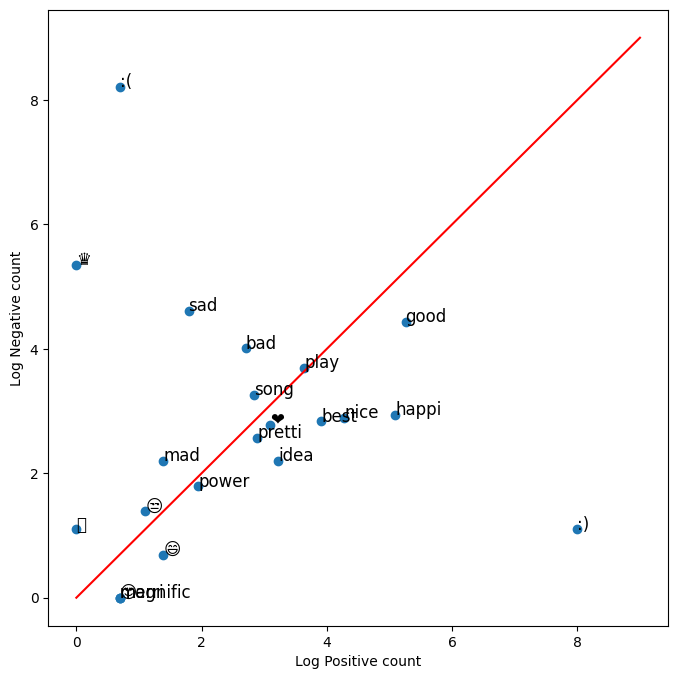

In [338]:
fig, ax = plt.subplots(figsize=(8, 8))

# convert positive raw counts to logarithmic scale. we add 1 to avoid log(0)
x = np.log([x[1] + 1 for x in data])

# do the same for the negative counts
y = np.log([x[2] + 1 for x in data])

# Plot a dot for each pair of words
ax.scatter(x, y)

# assign axis labels
plt.xlabel("Log Positive count")
plt.ylabel("Log Negative count")

# Add the word as the label at the same position as you added the points just before
for i in range(0, len(data)):
    ax.annotate(data[i][0], (x[i], y[i]), fontsize=12)

ax.plot([0, 9], [0, 9], color="red")  # Plot the red line that divides the 2 areas.
plt.show()


This chart is straightforward to interpret. It shows that emoticons `:)` and `:(` are very important for sentiment analysis. Thus, we should not let preprocessing steps get rid of these symbols!

Furthermore, what is the meaning of the crown symbol? It seems to be very negative!

### Extract Features

We will now implement a function that will take in a single tweet, process it and return its feature vector.

* Given a list of tweets, extract the features and store them in a matrix. You will extract two features.
    * The first feature is the number of positive words in a tweet.
    * The second feature is the number of negative words in a tweet. 
* Then train your logistic regression classifier on these features.
* Test the classifier on a validation set. 

**Instructions**:

Implement the extract_features function. 
* This function takes in a single tweet.
* Process the tweet using the imported `process_tweet` function and save the list of tweet words.
* Loop through each word in the list of processed words
    * For each word, check the `freqs` dictionary for the count when that word has a positive `1.0` label. (Check for the key `(word, 1.0)`).
    * Do the same for the count for when the word is associated with the negative label `0.0`. (Check for the key `(word, 0.0)`.)

**Note:** In the implementation instructions provided above, the prediction of being positive or negative depends on feature vector which counts-in duplicate words - this is different from what you have seen in the lecture videos.

In [339]:
tweet_1 = X_train[0]

tweet_1_processed = process_tweet(tweet_1)
pprint(tweet_1_processed)


['followfriday', 'top', 'engag', 'member', 'commun', 'week', ':)']

In [340]:
pprint(freqs, max_length=10)


{
│   ('followfriday', 1.0): 23,
│   ('top', 1.0): 30,
│   ('engag', 1.0): 7,
│   ('member', 1.0): 14,
│   ('commun', 1.0): 27,
│   ('week', 1.0): 72,
│   (':)', 1.0): 2960,
│   ('hey', 1.0): 60,
│   ('jame', 1.0): 7,
│   ('odd', 1.0): 2,
│   ... +11417
}

First, loop through each word `w` in the processed word list of each tweet and
check how many times `w` occurred in the positive sentiment class.

In [341]:
positive = 1.0
total_positive_freq = 0
for word in tweet_1_processed:
    word_sent: Tuple[str, int] = (word, positive)
    freq: int = freqs.get(word_sent, 0)
    total_positive_freq += freq


Note that it is important to use `freqs.get(word_sent, 0)` where if the
word is not found, we just set the frequency of this "non-existent" word to 0.

In [342]:
total_positive_freq


3133

In [343]:
negative = 0.0
total_negative_freq = 0
for word in tweet_1_processed:
    word_sent: Tuple[str, int] = (word, negative)
    freq: int = freqs.get(word_sent, 0)
    total_negative_freq += freq


In [344]:
total_negative_freq


61

Checking the expected output from the course notebook:

```
[[1.000e+00 3.133e+03 6.100e+01]]
```

we see that we are on the right track, and it's time for us to modularize the code.

In [345]:
def extract_features(
    tweet: str, freqs: Freq, process_tweet: Callable = process_tweet
) -> np.ndarray:
    # process_tweet tokenizes, stems, and removes stopwords
    word_list = process_tweet(tweet)

    # 3 elements for [bias, positive, negative] counts
    x = np.zeros(shape=(1, 3))

    # bias term is set to 1
    x[0, 0] = 1

    for word in word_list:
        pos_word_sent: Tuple[str, int] = (word, 1.0)
        neg_word_sent: Tuple[str, int] = (word, 0.0)
        pos_freq: int = freqs.get(pos_word_sent, 0)
        neg_freq: int = freqs.get(neg_word_sent, 0)

        x[0, 1] += pos_freq
        x[0, 2] += neg_freq

    assert x.shape == (1, 3)
    return x


In [346]:
# Check your function
# test 1
# test on training data
tmp1 = extract_features(X_train[0], freqs)
print(tmp1)


[[1.000e+00 3.133e+03 6.100e+01]]

In [347]:
# test 2:
# check for when the words are not in the freqs dictionary
tmp2 = extract_features("blorb bleeeeb bloooob", freqs)
print(tmp2)


[[1. 0. 0.]]

Both pass the test case!

## (Binary) Logistic Regression

The content below does not touch heavy on theory! So if you are interested in the theory behind logistic regression, you can check out my conceptual section, as well as
the references and further readings section in [Introduction](intro.md).

### Implement Sigmoid

You will learn to use logistic regression for text classification. 
* The sigmoid function is defined as: 

$$
h(\boldsymbol{z}) = \frac{1}{1+e^{(-\boldsymbol{z})}} \tag{1}
$$

It maps the input $\boldsymbol{z}$ to a value that ranges between $0$ and $1$, and so it can be treated as a probability. 

In [348]:
class Sigmoid(Activation):
    """
    Sigmoid activation function.

    Computes the gradient of the sigmoid function with respect to the input z.
    This is useful since in the backward pass for say
    Logistic Regression's Cross-Entropy Loss,
    dl/dz is needed in the chain rule, and dl/dz = dl/dA * dA/dz
    where A is y_pred is sigmoid(z).
    Consequently, dA/dz makes use of the gradient of the sigmoid function.
    """

    def __call__(self, z: T) -> T:
        """
        Compute the sigmoid function for a given input.

        Parameters
        ----------
        z : numpy.ndarray
            A numpy array of shape (batch_size, input_size).

        Returns
        -------
        numpy.ndarray
            A numpy array of shape (batch_size, output_size).
        """
        g = 1 / (1 + np.exp(-z))
        return g

    def gradient(self, z: T) -> T:
        """
        Compute the derivative of the sigmoid function with respect to its input.

        Parameters
        ----------
        z : numpy.ndarray
            A numpy array of shape (batch_size, input_size).

        Returns
        -------
        numpy.ndarray
            A numpy array of shape (batch_size, input_size).
        """
        g = self.__call__(z)
        dg_dz = g * (1 - g)
        return dg_dz


In [349]:
sigmoid = Sigmoid()

# Testing your function
if sigmoid(0) == 0.5:
    print("SUCCESS!")
else:
    print("Oops!")

if sigmoid(4.92) == 0.9927537604041685:
    print("CORRECT!")
else:
    print("Oops again!")


SUCCESS!

CORRECT!

In [350]:
# Test your function
# Test cases for the sigmoid function
test_cases = [
    {"name": "default_check", "input": {"z": 0}, "expected": 0.5},
    {
        "name": "positive_check",
        "input": {"z": 4.92},
        "expected": 0.9927537604041685,
    },
    {"name": "negative_check", "input": {"z": -1}, "expected": 0.2689414213699951},
    {
        "name": "larger_neg_check",
        "input": {"z": -20},
        "expected": 2.0611536181902037e-09,
    },
]


@pytest.mark.parametrize("test_case", test_cases)
def test_sigmoid(test_case):
    sigmoid = Sigmoid()

    # Call the sigmoid function with the input value
    result = sigmoid(test_case["input"]["z"])

    # Calculate the difference between the expected and obtained values
    difference = np.abs(result - test_case["expected"])
    print("\033[92m", "Difference:", difference)

    # Check if the result is close to the expected value using np.testing.assert_allclose
    try:
        np.testing.assert_allclose(result, test_case["expected"], rtol=1e-7, atol=1e-16)
    except AssertionError as e:
        pytest.fail(
            f"Test case '{test_case['name']}' failed: {str(e)}. Difference: {difference}"
        )


In [351]:
# !pytest -v {parent_dir}/src/tests/activations/test_activations.py::test_sigmoid


```bash
../../../../src/tests/activations/test_activations.py::test_sigmoid[test_case0] PASSED [ 25%]
../../../../src/tests/activations/test_activations.py::test_sigmoid[test_case1] PASSED [ 50%]
../../../../src/tests/activations/test_activations.py::test_sigmoid[test_case2] PASSED [ 75%]
../../../../src/tests/activations/test_activations.py::test_sigmoid[test_case3] PASSED [100%]

============================== 4 passed in 0.43s ===============================
```

### Sigmoid and Logistic Regression

Let's use our `sigmoid` to plot it.

Text(0.5, 1.0, 'Sigmoid Function')

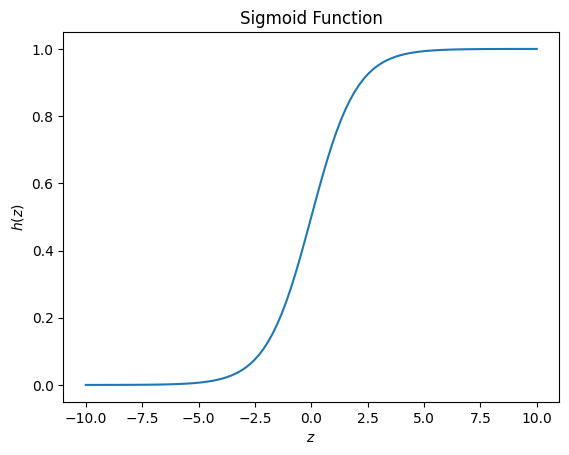

In [352]:
# plot sigmoid
z = np.linspace(-10, 10, 100)
h = sigmoid(z)

plt.plot(z, h)
plt.xlabel("$z$")
plt.ylabel("$h(z)$")
plt.title("Sigmoid Function")


Logistic regression takes a regular linear regression, and applies a 
sigmoid to the output of the linear regression.

Regression:

$$
\boldsymbol{z} = \theta_0 x_0 + \theta_1 x_1 + \cdots + \theta_D x_D
$$

where $D$ is the number of features, and $x_0$ is always 1 corresponding to 
the bias term $\theta_0$.

We can further collate the weights into a single vector $\boldsymbol{\theta}$:

$$
\boldsymbol{\boldsymbol{\theta}} = \begin{bmatrix}
\theta_0 \\
\theta_1 \\
\vdots \\
\theta_D
\end{bmatrix}_{(D+1) \times 1}
$$

Note that the $\boldsymbol{\theta}$ values are "weights".

If you took the deep learning specialization, we referred to the weights with the 'w' vector.  In this course, we're using a different variable $\boldsymbol{\theta}$ to refer to the weights.


Logistic regression:

$$ 
h(\boldsymbol{z}) = \frac{1}{1+e^{(-\boldsymbol{z})}} = \frac{1}{1+e^{-(\theta_0 x_0 + \theta_1 x_1 + \cdots + \theta_D x_D)}}
$$

where

$$
\boldsymbol{z} = \theta_0 x_0 + \theta_1 x_1 + \cdots + \theta_D x_D
$$

We will refer to $\boldsymbol{z}$ as the 'logits'.

### Cost Function


The cost function used for logistic regression is the average of the log loss across all training examples:

$$
\widehat{\mathcal{J}}(\boldsymbol{\theta}) = -\frac{1}{N} \sum_{n=1}^N y^{(n)}\log \left(h\left(\boldsymbol{z}\left(\boldsymbol{\theta}\right)^{(n)}\right)\right) + \left(1-y^{(n)}\right)\log \left(1-h\left(\boldsymbol{z}\left(\boldsymbol{\theta}\right)^{(n)}\right)\right)\tag{5} 
$$

* $N$ is the number of training examples
* $y^{(n)}$ is the actual label of training example $n$.
* $h(\boldsymbol{z}^{(n)})$ is the model's prediction for the training example $n$.

The loss function for a single training example is

$$
\widehat{\mathcal{L}}(\boldsymbol{z} ; \boldsymbol{\theta}) = -1 \times \left( y^{(n)}\log \left(h\left(\boldsymbol{z}\left(\boldsymbol{\theta}\right)^{(n)}\right)\right) + \left(1-y^{(n)}\right)\log \left(1-h\left(\boldsymbol{z}\left(\boldsymbol{\theta}\right)^{(n)}\right)\right) \right)
$$

* All the $h$ values are between 0 and 1, so the logs will be negative. That is the reason for the factor of -1 applied to the sum of the two loss terms.
* Note that when the model predicts 1 ($h(\boldsymbol{z}(\boldsymbol{\theta})) = 1$) and the label $y$ is also 1, the loss for that training example is 0.
* Similarly, when the model predicts 0 ($h(\boldsymbol{z}(\boldsymbol{\theta})) = 0$) and the actual label is also 0, the loss for that training example is 0.
* However, when the model prediction is close to 1 ($h(\boldsymbol{z}(\boldsymbol{\theta})) = 0.9999$) and the label is 0, the second term of the log loss becomes a large negative number, which is then multiplied by the overall factor of -1 to convert it to a positive loss value. $-1 \times (1 - 0) \times log(1 - 0.9999) \approx 9.2$ The closer the model prediction gets to 1, the larger the loss.

In [353]:
# verify that when the model predicts close to 1, but the actual label is 0, the loss is a large positive value
-1 * (1 - 0) * np.log(1 - 0.9999)  # loss is about 9.2


9.210340371976294

* Likewise, if the model predicts close to 0 ($h(z) = 0.0001$) but the actual label is 1, the first term in the loss function becomes a large number: $-1 \times log(0.0001) \approx 9.2$.  The closer the prediction is to zero, the larger the loss.

In [354]:
# verify that when the model predicts close to 0 but the actual label is 1, the loss is a large positive value
-1 * np.log(0.0001)  # loss is about 9.2


9.210340371976182

### Gradient Descent

#### Update the weights

To update your weight vector $\boldsymbol{\theta}$, you will apply gradient descent to iteratively improve your model's predictions.  
The gradient of the cost function $\widehat{\mathcal{J}}$ with respect to one of the weights $\theta_j$ is:

$$
\nabla_{\theta_j}\widehat{\mathcal{J}}(\theta) = \frac{1}{N} \sum_{n=1}^N\left(h^{(n)}-y^{(n)}\right)x^{(n)}_j \tag{5}
$$

* $i$ is the index across all $N$ training examples.
* $j$ is the index of the weight $\theta_j$, so $x^{(n)}_j$ is the feature associated with weight $\theta_j$

* To update the weight $\theta_j$, we adjust it by subtracting a fraction of the gradient determined by $\alpha$:
  
$$
\theta_j = \theta_j - \alpha \times \nabla_{\theta_j}\widehat{\mathcal{J}}(\boldsymbol{\theta})
$$

* The learning rate $\alpha$ is a value that we choose to control how big a single update will be.

#### Implement Gradient Descent

* The number of iterations `num_iters` is the number of times that you'll use the entire training set.
* For each iteration, you'll calculate the cost function using all training examples (there are $N$ training examples), and each sample has $D$ features.
* Instead of updating a single weight $\theta_i$ at a time, we can update all the weights in the column vector:  
  
$$
\boldsymbol{\theta} = \begin{bmatrix}
\theta_0
\\
\theta_1
\\ 
\theta_2 
\\ 
\vdots
\\ 
\theta_D
\end{bmatrix}_{(D+1, 1)}
$$

* $\boldsymbol{\theta}$ has dimensions $(D+1, 1)$, where $D$ is the number of features, and there is one more element for the bias term $\theta_0$ (note that the corresponding feature value $\boldsymbol{x}_0$ is 1).
* The logits of one single sample $\boldsymbol{x}^{(n)}$ is calculated by
    multiplying the feature vector $\boldsymbol{x}^{(n)}$ with the weight vector $\boldsymbol{\theta}$: 
    
    $$
    \boldsymbol{z}^{(n)} = \boldsymbol{\theta}^T\boldsymbol{x}^{(n)}
    $$
* To get all logits for every sample $1, 2, \ldots N$, we denote $\boldsymbol{Z}$ as
    as the logits for all $N$ samples, which is calculated by multiplying the feature matrix $\boldsymbol{X}$ with the weight vector $\boldsymbol{\theta}$.  
    * $\boldsymbol{Z} = \boldsymbol{X}\boldsymbol{\theta}$
    * $\boldsymbol{X}$ has dimensions $(N, D+1)$ 
    * $\boldsymbol{\theta}$: has dimensions $(D+1, 1)$
    * $\boldsymbol{Z}$: has dimensions $(N, 1)$
* The prediction $h(\boldsymbol{Z})$, is calculated by applying the sigmoid to each element in $\boldsymbol{Z}$: $h(\boldsymbol{Z}) = \text{sigmoid}(\boldsymbol{Z})$, and has dimensions $(N, 1)$.
* The cost function $\widehat{\mathcal{J}}$ is calculated by taking the dot product of the vectors $\boldsymbol{y}$ and $\log(\boldsymbol{h})$.  Since both $\boldsymbol{y}$ and $\boldsymbol{h}$ are column vectors $(N, 1)$, transpose the vector to the left, so that matrix multiplication of a row vector with column vector performs the dot product.
  
$$
\widehat{\mathcal{J}} = -\frac{1}{N} \times \left(\mathbf{y}^T \cdot \log(\mathbf{h}) + \mathbf{(1-y)}^T \cdot \log(\mathbf{1-h}) \right)
$$

* The update of theta is also vectorized.  Because the dimensions of $\boldsymbol{X}$ are $(N, D+1)$, and both $\boldsymbol{h}$ and $\boldsymbol{y}$ are $(N, 1)$, we need to transpose the $\boldsymbol{X}$ and place it on the left in order to perform matrix multiplication, which then yields the $(D+1, 1)$ answer we need:
  
$$
\boldsymbol{\theta} = \boldsymbol{\theta} - \alpha\frac{1}{N} \times \left( \boldsymbol{X}^T \cdot \left( \boldsymbol{h-y} \right) \right)
$$


In [355]:
class BinaryCrossEntropy(Criterion):
    def __init__(self, epsilon: float = 1e-10, reduction: str = "mean") -> None:
        """
        Initialize the BinaryCrossEntropy criterion.

        Parameters
        ----------
        epsilon : float, optional
            Small constant to avoid division by zero or log(0) issues,
            by default 1e-10.
        reduction : str, optional
            Specifies the reduction to apply to the output: 'none' | 'mean',
            by default 'mean'.
        """
        self.epsilon = epsilon
        self.reduction = reduction

    @staticmethod
    def _loss(y_trues: T, y_probs: T) -> T:
        return y_trues * np.log(y_probs) + (1 - y_trues) * np.log(1 - y_probs)

    @staticmethod
    def _total_loss(loss: T) -> float:
        # we sum up all the loss for each individual sample.
        return -np.sum(loss, axis=None)

    def _mean_loss(self, loss: float, num_samples: int) -> float:
        # we then average out the total loss across m samples.
        total_loss = self._total_loss(loss)
        return np.squeeze(total_loss / num_samples, axis=None)

    def __call__(self, y_trues: T, y_probs: T) -> Union[float, T]:
        """
        Compute the cross entropy loss between predicted and true class labels.
        Assume that y_true is one-hot encoded.

        Parameters
        ----------
        y_probs : numpy.ndarray
            Predicted class probabilities with shape (batch_size, num_classes).
        y_trues : numpy.ndarray
            True class labels with shape (batch_size, ).

        Returns
        -------
        Union[float, numpy.ndarray]
            The cross entropy loss summed or averaged over all samples in the
            batch if reduction is 'sum' or 'mean' respectively. If reduction is
            'none', then the output is a numpy array of shape (batch_size, )
            same shape as y_true and y_pred.
        """
        # Consider to check y_true is a one-hot encoded matrix
        num_samples = y_trues.shape[0]

        # clip y_probs to avoid log(0) issues
        y_probs = np.clip(y_probs, self.epsilon, 1.0 - self.epsilon)

        # loss_matrix is same shape as y_true and y_pred since we are
        # just performing element wise operations on both of them.
        loss = self._loss(y_trues, y_probs)
        np.testing.assert_array_equal(loss.shape, y_trues.shape)

        if self.reduction == "none":
            return loss

        if self.reduction == "sum":
            return self._total_loss(loss)

        if self.reduction == "mean":
            # we then average out the total loss across m samples, but we squeeze it to
            # make it a scalar; squeeze along axis = None since there is no column axix
            mean_loss = self._mean_loss(loss, num_samples)
            return mean_loss


In [356]:
sigmoid = Sigmoid()
criterion = BinaryCrossEntropy(reduction="mean")

In [357]:
# UNQ_C2 GRADED FUNCTION: gradientDescent
def gradientDescent(X, y, theta, alpha, num_iters):
    """
    Input:
        X: matrix of features which is (N , D+1)
        y: corresponding labels of the input matrix x, dimensions (m,1)
        theta: weight vector of dimension (n+1,1)
        alpha: learning rate
        num_iters: number of iterations you want to train your model for
    Output:
        J: the final cost
        theta: your final weight vector
    Hint: you might want to print the cost to make sure that it is going down.
    """
    
    N, D = X.shape
    
    for t in range(0, num_iters):
        # get z, the dot product of x and theta
        Z = X @ theta

        # get the sigmoid of z
        h = sigmoid(Z)

        # calculate the cost function
        J = criterion(y_trues=y, y_probs=h)
        
        nabla_J = X.T @ (h - y) # or -X.T @ (y - h)
        mean_nabla_J = nabla_J / N

        # update the weights theta
        theta -= alpha * mean_nabla_J

    ### END CODE HERE ###
    J = float(J)
    return J, theta
    

In [358]:
# Check the function
# Construct a synthetic test case using numpy PRNG functions
np.random.seed(1)
# X input is 10 x 3 with ones for the bias terms
tmp_X = np.append(np.ones((10, 1)), np.random.rand(10, 2) * 2000, axis=1)
# Y Labels are 10 x 1
tmp_Y = (np.random.rand(10, 1) > 0.35).astype(float)

# Apply gradient descent
tmp_J, tmp_theta = gradientDescent(tmp_X, tmp_Y, np.zeros((3, 1)), 1e-8, 700)
print(f"The cost after training is {tmp_J:.8f}.")
print(
    f"The resulting vector of weights is {[round(t, 8) for t in np.squeeze(tmp_theta)]}"
)


The cost after training is 0.67094970.

The resulting vector of weights is [4.1e-07, 0.00035658, 7.309e-05]

The results look good! Same as what the course expected us to get!